In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

pd.set_option('display.max_columns',36)

In [4]:
st.title('Probability of company defaulting')

2022-10-26 11:24:54.355 
  command:

    streamlit run C:\Users\Brandi\miniconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

The dataset "Technical Task Dataset.csv" contains company level data at yearly granularity. Each row corresponds to data from a company. There are five rows per company, each corresponding to a financial account from a different year.

The "Trading Status" field indicates the case where a company has defaulted. Active = nondefault, Dissolved or Liquidated/Receivership = default.

Using the data provided, please create a model that returns the probability that a company defaults given a set of inputs that you define.

Please restrict your analysis to data in the last financial account (i.e., "Account Year" = year in "Latest Accounts Date").

You may rely on any available literature and material to assist, but please use Python to code the model.

Once you’ve built your model, use an open-source app framework of your choice (e.g., Streamlit, Hex, etc) to turn your algorithm into a data-app that can be used to illustrate your model (e.g., inputs, outputs, visualizations, etc). You are free to illustrate your model via the data-app in whatever way you think is suitable. Think of business users as your audience.

Please include in your solution answers to the following questions:
1. In two or three paragraphs, please describe your methodological approach to the problem (e.g., how you framed the problem, any assumptions you made, why you chose certain techniques, etc). If applicable, please include any references to the literature that you used.
2. In 3 bullet points, please explain what feedback you'd give to the engineering team responsible for the data API to help them improve any aspect of the tool that you think would benefit.
3. In 3 bullet points, please give guidance to the business regarding any suggestions you'd give them for using this model in production.
4. What two things would you do to improve this test? One line for each.

In [2]:
df = pd.read_csv('Technical Task Dataset.csv')

In [39]:
df1 = df.query('1900 < `Account Year` < 2023')

In [63]:
df2 = df[df.index.isin(df1.index)]

In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68575 entries, 0 to 68649
Data columns (total 36 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Registered Number                                68575 non-null  object 
 1   Date of Incorporation                            68570 non-null  object 
 2   Latest Accounts Date                             68575 non-null  object 
 3   Account Year                                     68575 non-null  float64
 4   Trading Status                                   68575 non-null  object 
 5   UK SIC Code                                      68575 non-null  float64
 6   Registered or Trading Postcode                   68490 non-null  object 
 7   Bank Overdraft                                   35944 non-null  float64
 8   Bank Postcode                                    28960 non-null  object 
 9   Capital Expenditure         

In [65]:
for col in df2.columns:
    if df[col].dtype == 'object':
        try:
            df2[col] = pd.to_datetime(df2[col])
        except ValueError:
            pass

C:\Users\Brandi\AppData\Local\Temp/ipykernel_21784/2353909976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = pd.to_datetime(df2[col])


In [67]:
df3 = df2.convert_dtypes()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68575 entries, 0 to 68649
Data columns (total 36 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Registered Number                                68575 non-null  string        
 1   Date of Incorporation                            68570 non-null  datetime64[ns]
 2   Latest Accounts Date                             68575 non-null  datetime64[ns]
 3   Account Year                                     68575 non-null  Int64         
 4   Trading Status                                   68575 non-null  string        
 5   UK SIC Code                                      68575 non-null  Int64         
 6   Registered or Trading Postcode                   68490 non-null  string        
 7   Bank Overdraft                                   35944 non-null  Int64         
 8   Bank Postcode                       

In [74]:
df4 = df3[df3['Latest Accounts Date'].dt.year==df3['Account Year']]

In [88]:
df4

,Registered Number,Date of Incorporation,Latest Accounts Date,Account Year,Trading Status,UK SIC Code,Registered or Trading Postcode,Bank Overdraft,Bank Postcode,Capital Expenditure,Cash At Bank,Director Loans (current),Director Loans (non-current),Directors Remuneration,EBIT,EBITDA,EBITDA + Directors Remuneration,Employees Remuneration,Highest Paid Director,Intangible Assets,Interest Expense,Leasehold,Number of Employees,Profit Before Tax + Directors Remuneration,Profit For The Year,"Property, Plant & Equipment",Retained Earnings,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Non Current Assets,Total Non Current Liabilities (Incl Provisions),Total Sales / Turnover,Wages,Working Capital
0,340228,1938-12-05 01:00:00,2006-09-30 01:00:00,2006,Liquidated/Receivership,1629,M3 3WR,2084953,SK11 6BS,-286133,1143.0,<NA>,0,180449,-589010,-346093,-165644,1629707,<NA>,0,309059,0,57,-482620,-636762,5576567,617128,7216172.0,1540296.0,3419378,3249408,5675876.0,547386.0,5611658,1448224,-1879082.0
5,3959210,2000-03-24 00:00:00,2015-11-30 00:00:00,2015,Liquidated/Receivership,4339,NW1 6BB,<NA>,<NA>,-22548,1584330.0,0,0,225190,466774,485428,710618,1170260,<NA>,0,0,0,17,696567,367362,43881,631673,4788564.0,4744683.0,4156879,631685,43881.0,0.0,14269555,1057211,587804.0
10,6511203,2008-02-21 00:00:00,2017-03-31 01:00:00,2017,Liquidated/Receivership,7010,EN6 3JN,0,<NA>,<NA>,0.0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,0,<NA>,<NA>,<NA>,0,0,103.0,1.0,0,103,102.0,0.0,<NA>,<NA>,1.0
15,5808052,2006-05-05 01:00:00,2012-05-31 01:00:00,2012,Liquidated/Receivership,4652,LS1 4DL,314186,<NA>,-170,28526.0,538207,0,0,1848576,1849855,1849855,<NA>,0,0,2295,0,<NA>,1846281,1354436,2770,1509896,7155230.0,6529690.0,5045334,2109896,625540.0,0.0,74382968,<NA>,1484356.0
20,3649149,1998-08-10 01:00:00,2017-12-31 00:00:00,2017,Liquidated/Receivership,8299,SG14 1HH,1085000,<NA>,0,1656000.0,<NA>,0,113000,2262000,3090000,3203000,4468000,<NA>,1510000,71000,2356000,86,2319000,1840000,8158000,10582000,31067000.0,21399000.0,6889000,23035000,9668000.0,1143000.0,66895000,3697000,14510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68625,2023610,1986-05-28 01:00:00,2000-12-31 00:00:00,2000,Active,4339,EX15 1BT,1148181,<NA>,-57623,113.0,34618,0,61800,73040,155574,217374,472988,<NA>,251756,106898,<NA>,<NA>,27942,-34574,148180,254483,3472847.0,3072911.0,3184835,257085,399936.0,30927.0,6983198,<NA>,-111924.0
68630,1126125,1973-02-08 01:00:00,1993-09-30 01:00:00,1993,Active,4120,M2 3PW,2961171,<NA>,<NA>,<NA>,<NA>,<NA>,205701,554035,2324012,2529713,12020939,<NA>,0,942614,<NA>,623,-182878,-84893,6211840,-856283,20862580.0,14150740.0,13327267,2107825,6711840.0,5427488.0,47481528,<NA>,823473.0
68635,451454,1948-03-25 01:00:00,2008-03-31 01:00:00,2008,Active,8299,LS1 2NE,<NA>,G1 2HL,<NA>,2067442.0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,0,<NA>,<NA>,<NA>,0,594810,2068693.0,2067442.0,522136,1546557,1251.0,0.0,<NA>,<NA>,1545306.0
68640,339806,1938-04-30 01:00:00,2001-04-30 01:00:00,2001,Active,41,EC4A 4HT,0,SW1Y 5EU,-128579,952128.0,<NA>,0,215105,361871,428579,643684,4380023,<NA>,0,48106,<NA>,146,528870,313765,986118,1612441,7905433.0,6912265.0,5733852,2102130,993168.0,69451.0,19058892,<NA>,1178413.0


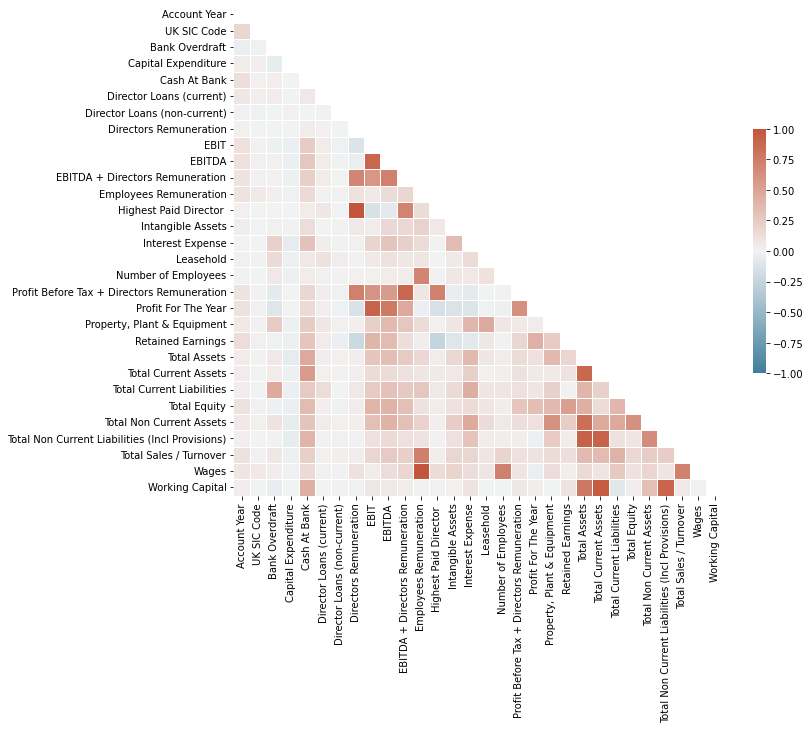

In [97]:
# Compute the correlation matrix
corr = df4.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, #annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [94]:
df4.describe()

,Account Year,UK SIC Code,Bank Overdraft,Capital Expenditure,Cash At Bank,Director Loans (current),Director Loans (non-current),Directors Remuneration,EBIT,EBITDA,EBITDA + Directors Remuneration,Employees Remuneration,Highest Paid Director,Intangible Assets,Interest Expense,Leasehold,Number of Employees,Profit Before Tax + Directors Remuneration,Profit For The Year,"Property, Plant & Equipment",Retained Earnings,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Non Current Assets,Total Non Current Liabilities (Incl Provisions),Total Sales / Turnover,Wages,Working Capital
count,13715.000000,13715.000000,6.314000e+03,9.314000e+03,1.352600e+04,4.146000e+03,1.112600e+04,1.027100e+04,1.187900e+04,1.187900e+04,1.187900e+04,1.059700e+04,6.043000e+03,1.348200e+04,1.186900e+04,9.561000e+03,11941.000000,1.187900e+04,1.187900e+04,1.361000e+04,1.366600e+04,1.306100e+04,1.370000e+04,1.370000e+04,1.370000e+04,1.369900e+04,1.369800e+04,1.159000e+04,9.983000e+03,1.369500e+04
mean,2015.877579,15067.144295,1.190052e+06,-7.854715e+04,2.251905e+06,2.209758e+05,4.200742e+04,4.109253e+05,1.196251e+06,1.866701e+06,2.220793e+06,5.472700e+06,2.562084e+05,1.337567e+06,4.549229e+05,4.353248e+05,182.597605,1.208800e+06,6.524726e+05,6.168389e+06,4.251673e+06,2.159260e+07,1.071873e+07,6.987889e+06,7.443336e+06,1.071059e+07,6.885016e+06,2.256149e+07,4.963649e+06,3.742558e+06
std,5.342515,21004.332491,6.947387e+06,2.755542e+06,6.271556e+06,1.198371e+06,1.116891e+06,5.512659e+06,4.808039e+06,5.499866e+06,7.388902e+06,1.076100e+07,5.646051e+06,9.979983e+06,2.130392e+06,3.006066e+06,884.505085,6.578681e+06,4.463438e+06,3.009119e+07,1.868645e+07,1.012147e+08,6.398577e+07,1.884583e+07,2.849441e+07,5.358217e+07,8.823601e+07,3.244026e+07,9.227127e+06,6.283860e+07
min,1987.000000,41.000000,0.000000e+00,-2.040000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.847600e+07,-8.176900e+07,-8.052700e+07,0.000000e+00,0.000000e+00,-2.692300e+07,-1.600000e+06,-1.479340e+05,0.000000,-8.693600e+07,-7.163000e+07,0.000000e+00,-4.894050e+08,3.000000e+00,0.000000e+00,0.000000e+00,-1.794690e+08,-2.687100e+07,0.000000e+00,-1.166240e+05,0.000000e+00,-1.020163e+09
25%,2018.000000,4639.000000,0.000000e+00,0.000000e+00,7.995250e+04,0.000000e+00,0.000000e+00,7.065500e+04,9.770950e+04,3.233390e+05,4.685580e+05,1.704912e+06,6.892900e+04,0.000000e+00,4.937000e+03,0.000000e+00,40.000000,1.262295e+05,0.000000e+00,1.475350e+05,2.277522e+05,4.961529e+06,2.017214e+06,1.409418e+06,8.343085e+05,6.299380e+05,3.438150e+04,6.930963e+06,1.584044e+06,-1.329830e+05
50%,2018.000000,7010.000000,1.037255e+05,0.000000e+00,6.035570e+05,0.000000e+00,0.000000e+00,2.077180e+05,5.506060e+05,9.210880e+05,1.160906e+06,3.229906e+06,1.391930e+05,0.000000e+00,6.023800e+04,0.000000e+00,88.000000,6.577890e+05,3.641350e+05,1.231199e+06,1.898940e+06,9.338859e+06,4.975372e+06,3.339118e+06,2.934738e+06,2.639696e+06,5.274140e+05,1.431260e+07,2.944454e+06,9.883420e+05
75%,2019.000000,8621.000000,7.333112e+05,0.000000e+00,2.187075e+06,7.409450e+04,0.000000e+00,4.279490e+05,1.495236e+06,2.114781e+06,2.468805e+06,6.131014e+06,2.203065e+05,2.379848e+05,2.088540e+05,5.209800e+04,178.000000,1.644152e+06,1.100926e+06,4.525228e+06,5.467374e+06,1.903900e+07,1.034181e+07,7.194226e+06,7.398847e+06,7.274982e+06,2.616989e+06,2.755934e+07,5.597448e+06,3.553866e+06
max,2020.000000,93199.000000,2.681330e+08,5.136359e+07,3.109100e+08,3.272314e+07,8.148748e+07,5.340290e+08,2.094500e+08,2.094500e+08,4.943620e+08,7.510000e+08,4.385440e+08,6.283250e+08,8.548000e+07,1.004710e+08,86954.000000,4.651450e+08,2.094500e+08,1.942283e+09,4.212720e+08,9.434203e+09,6.782717e+09,1.093023e+09,1.758609e+09,2.784330e+09,9.413008e+09,2.035000e+09,5.790000e+08,6.761523e+09


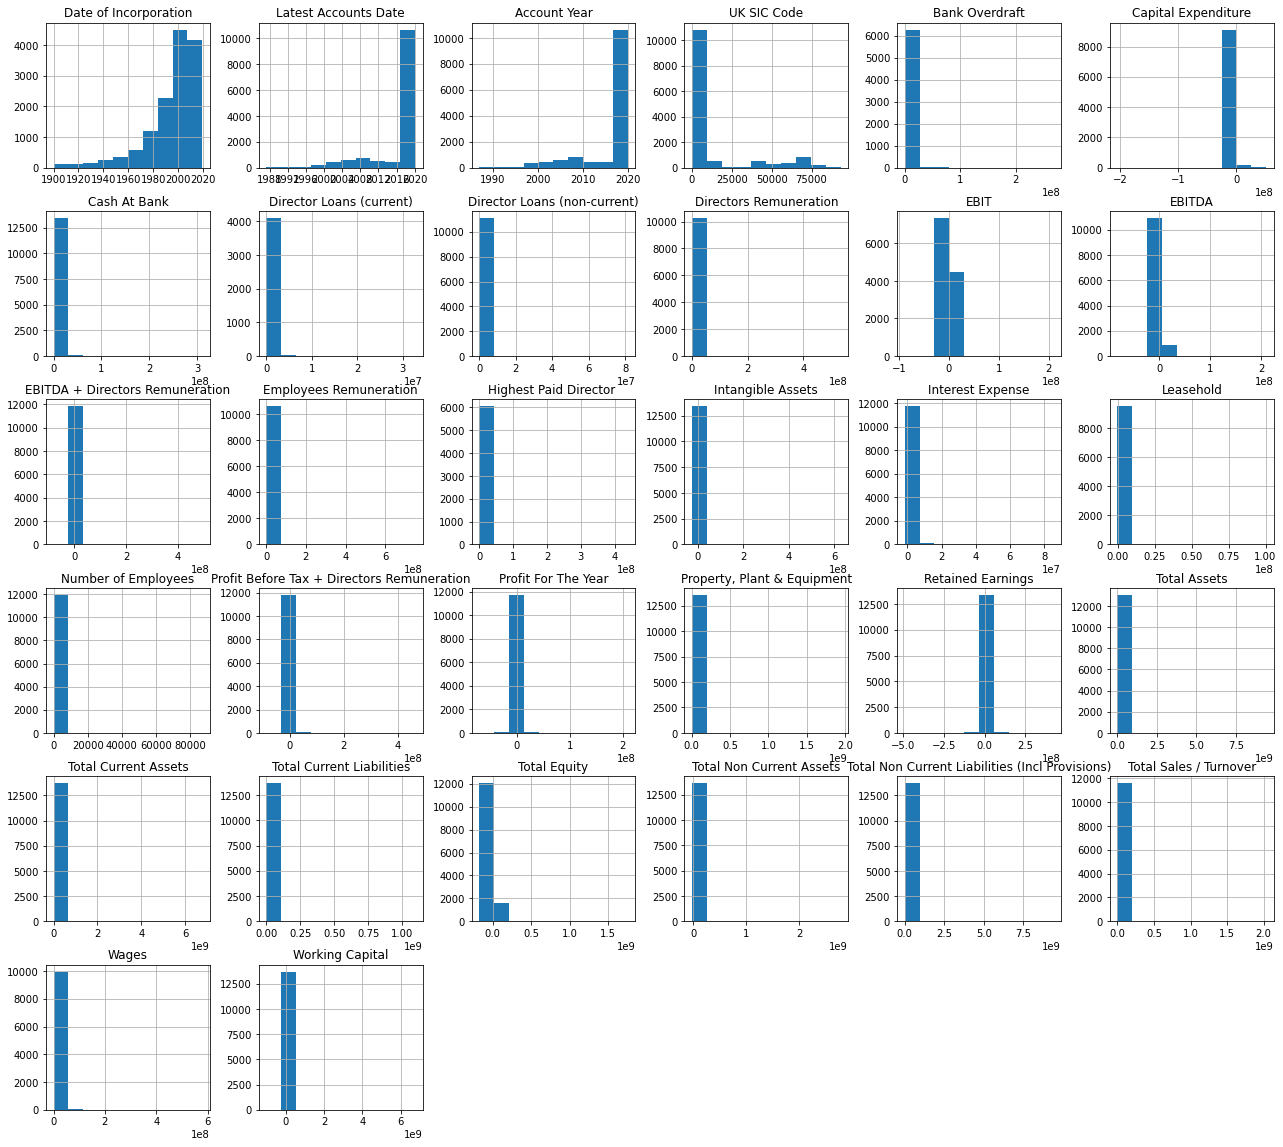

In [92]:
df4.hist( figsize = (22, 20) )
plt.show()

In [93]:
df4['Trading Status'].value_counts()

Active                     10746
Dissolved                   2652
Liquidated/Receivership      317
Name: Trading Status, dtype: Int64